# ndd module Tutorial

Welcome to the ndd (eNtropy from Discrete Data) module Tutorial

## What is this about

The main goal of **ndd** is to provide a simple and minimal Python interface to the Nemenman-Shafee-Bialek (NSB)  algorithm, a state of the art Bayesian algorithm for entropy estimation. In **ndd**, this interface is the ndd.entropy() function, that returns an estimate from an array of counts over a set of outcomes: entropy_estimate = ndd.entropy(counts). In turn, ndd.entropy() relies on an efficient and numerically robust Fortran implementation of the NSB algorithm. 

## Entropy and dice rolls

In this tutorial we will test the **ndd** module on some simple datasets. 
First, import the module:

In [1]:
import ndd

we will also need numpy and plotting libraries

In [2]:
import numpy as np
from matplotlib import pylab

#tell matplotlib to plot inline
%matplotlib inline

#increase the font size and markers size
from matplotlib import rc
rc('font', size=20)
rc('lines', markersize=12)

We need a list of integers $\{n_i\} \equiv \{n_1,n_2,...,n_k\}$ representing counts of the occurrences of values within a set of $k$ possible outcomes. For example, we can roll a six-sided dice ($k$ = 6 possible outcomes) for 1000 times and count the number of times we observe the six different faces:

In [3]:
def dice_rolls(k,n):
    p = np.ones(k)
    p /= np.sum(p)
    counts = np.random.multinomial(n,p)
    return counts
k = 6
n = 1000
counts = dice_rolls(k,n)
print({i+1:ni for i,ni in enumerate(counts)})

{1: 159, 2: 157, 3: 167, 4: 173, 5: 162, 6: 182}


We can also define an "unfair", loaded dice where the probability of one of the faces is double than the others:

In [4]:
def loaded_dice_rolls(k,n,w=100):
    p = np.ones(k)
    p[::2] = p[::2]*w
    p /= np.sum(p)
    counts = np.random.multinomial(n,p)
    return counts

For a fair dice, the probability of each face is exactly $\pi_i = 1/6$ and the entropy $H({\boldsymbol \pi})$ of the probability distribution ${\boldsymbol \pi}$ over the 6 different faces is exactly $\log(6)$. To test whether the dice is fair, we can use our empirical counts and estimate the entropy for the probability distribution. 

In [5]:
H_true = np.log(6.0)
H_nsb = ndd.entropy(counts)
print('true entropy: %s' % H_true)
print('NSB     est.: %s' % H_nsb)

true entropy: 1.79175946923
NSB     est.: 1.79010354999


We can compare this result with the standard "plugin" estimator $H_{\rm plugin}(\{n_i\}) = \sum_{i=1,k} \left(\frac{n_i}{n}\right) \log \left(\frac{n_i}{n}\right)$ (as implemented in the scipy.stats library):

In [6]:
import scipy.stats
H_plugin = scipy.stats.entropy(counts)
print('plugin  est.: %s' % H_plugin)
print('plugin  est.: %s' % ndd.entropy(counts,algorithm='plugin'))



plugin  est.: 1.79042468351
plugin  est.: 1.79042468351


In [7]:
def plotter(k,n):
    x = np.array([ndd.entropy(dice_rolls(k,n)) for i in range(1000)])
    hist,bins,patches = pylab.hist(x,bins=20,normed=1,facecolor='green',alpha=0.75)

In [ ]:
def plotter(k,n):    
    x = [[scipy.stats.entropy(dice_rolls(k,n)),ndd.entropy(dice_rolls(k,n),algorithm='plugin')] for i in range(10000)]
    y = np.array(x)
    #z = np.array([ndd.entropy(dice_rolls(k,n),algorithm='plugin') for i in range(1000)])
    hist,bins,patches = pylab.hist(y[:,0],bins=20,normed=1,facecolor='green',alpha=0.75)
    hist,bins,patches = pylab.hist(y[:,1],bins=20,normed=1,facecolor='red',alpha=0.75)
    #hist,bins,patches = pylab.hist(z,bins=20,normed=1,facecolor='blue',alpha=0.75)
k=1000;n=2000

pylab.figure(figsize=(12,6))

plotter(k,n)
#plotter(scipy.stats.entropy,'red',fair_data)

Actually, we are more interested in the opposite situation, i.e. when the number of possible outcomes is much larger than the number of trials; for example the more unusual experiment consisting in throwing a 1000-faced dice for 6 times. 

In [ ]:
k = 1000
n = 6
counts = dice_rolls(k,n)
print('true entropy: %s' % np.log(k))
print('NSB     est.: %s,%s' % ndd.entropy(counts,est_error=True))
print('plugin  est.: %s' % scipy.stats.entropy(counts))

or larger numbers:

In [ ]:
k = int(1.e8)
n = int(1.e4)
counts = dice_rolls(k,n)
print('true entropy: %s' % np.log(k))
print('NSB     est.: %s,%s' % ndd.entropy(counts,est_error=True))
print('plugin  est.: %s' % scipy.stats.entropy(counts))

In [ ]:
k = int(1.e8)
n = int(1.e4)
counts = dice_rolls(k,n)
print('true entropy: %s' % np.log(k))
print('NSB     est.: %s' % ndd.entropy(counts))
print('plugin  est.: %s' % scipy.stats.entropy(counts+1))

some timings comparison with the scipy implementation of the standard algorithm: 

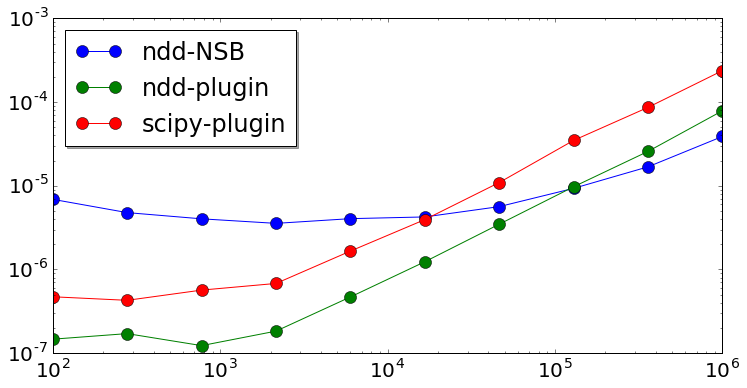

In [21]:
def timer(func,data): 
    import time
    t0 = time.time()
    s = func(data)
    return (time.time() - t0)
def ndd_plugin(data):
    return ndd.entropy(data,algorithm='plugin')

nrep = 20
names = ['ndd-NSB','ndd-plugin','scipy-plugin']
algorithms = [ndd.entropy,ndd_plugin,scipy.stats.entropy]
nalg = len(algorithms)

norder = 6
npoints = (norder-1)*2
X = [int(x) for x in np.logspace(2,norder,npoints)]
Y = np.zeros((npoints,nalg))
for j,t in enumerate(X):
    k = t; n = t # we will use n = k
    counts = dice_rolls(k,n)
    for rep in range(10):
        for i,alg in enumerate(algorithms):
            Y[j,i] += timer(alg,counts)
Y /= float(nrep)
pylab.figure(figsize=(12,6))
for i,alg in enumerate(algorithms):
    pylab.loglog(X,Y[:,i],'-o',label=names[i])    
pylab.legend(loc='upper left', shadow=True)

In [74]:
k=100000000
n=100000000
dice = np.random.random_integers(1,k,n)
counts = np.bincount(dice-1,minlength=k)
print np.log(k)

t0 = time.time(); s = ndd.entropy(counts); dt = time.time() - t0; print s,dt
t0 = time.time(); s = scipy.stats.entropy(counts); dt = time.time() - t0; print s,dt

18.420680744
18.4205769305 0.926295995712
18.4205769305 0.935376882553
17.8472295048 4.56956005096


In [55]:
k=10000000
n=10000000
dice = np.random.random_integers(1,k,n)
counts = np.bincount(dice-1)
print np.log(k),ndd.entropy(counts),ndd.entropy(counts,k=k)
import scipy.stats
print scipy.stats.entropy(counts)

16.118095651 16.1175709633 16.1175709633
15.5442962988


In [60]:
k=1000000000
n=10000
dice = np.random.random_integers(1,k,n)
counts = np.bincount(dice-1)
print np.log(k),ndd.entropy(counts),ndd.entropy(counts,k=k)
import scipy.stats
print scipy.stats.entropy(counts)

20.7232658369 19.4644984286 19.4645771542
9.21034037198


[['Washington' 'DC']
 ['Chicago' 'IL']
 ['Atlanta' 'GA']
 ['Miami' 'FL']
 ['Pittsburgh' 'PA']
 ['Philadelphia' 'PA']
 ['Wichita' 'KS']
 ['Peoria' 'IL']
 ['Charlotte' 'NC']
 ['Topeka' 'KS']]
[262 184 113  98  81  79  78  76  71  70]
26016 17807 14716.29774


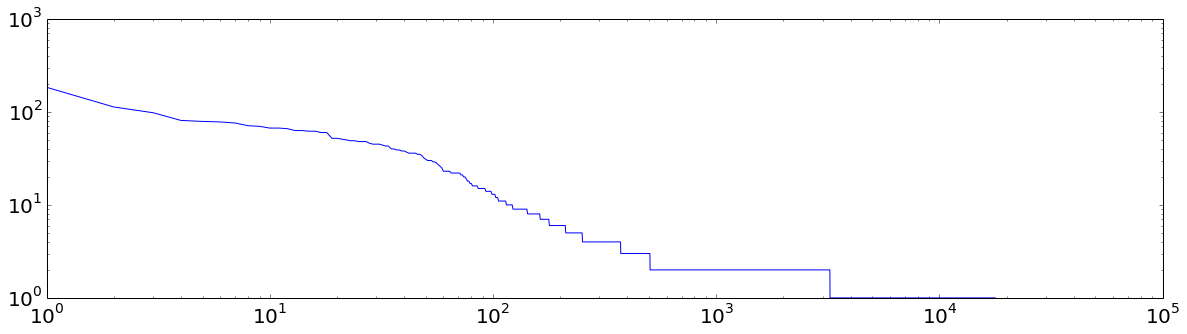

In [16]:
zips = []
with open('./zipdelim.txt','r') as f: zips.extend([line.split()[:2] for line in f if len(line.split()) == 3])
zips = np.asarray(zips)
towndict = ndd.histogram(zips,dictionary=True)
towns = np.asarray(towndict.keys())
counts = np.asarray(towndict.values())
inds = np.argsort(counts)[::-1]
print towns[inds][:10]
print counts[inds][:10]
nzip,ntowns,neff = len(zips),len(counts),np.exp(ndd.entropy(counts))
print nzip,ntowns,neff
x = np.arange(ntowns)
pylab.figure(figsize=(20,5))
pylab.loglog(x,counts[inds])
            

In [ ]:
## Entropy from histograms

To test **ndd**, we will first need a list of integers representing frequencies or counts of the occurrences of values within a set of $k$ possible outcomes. 
In the following lines, we first generate a random Dirichlet distribution *pp* (according to the value of the *a* parameter and the number of symbols in the alphabet of the random variable)

then we will generate a random histogram with *nd* entries from *pp* 

In [6]:
def plugin(h):
    n = np.float64(np.sum(h))
    q = h[h>0]
    return -np.sum(q*np.log(q))/n + np.log(n)

194481


[]

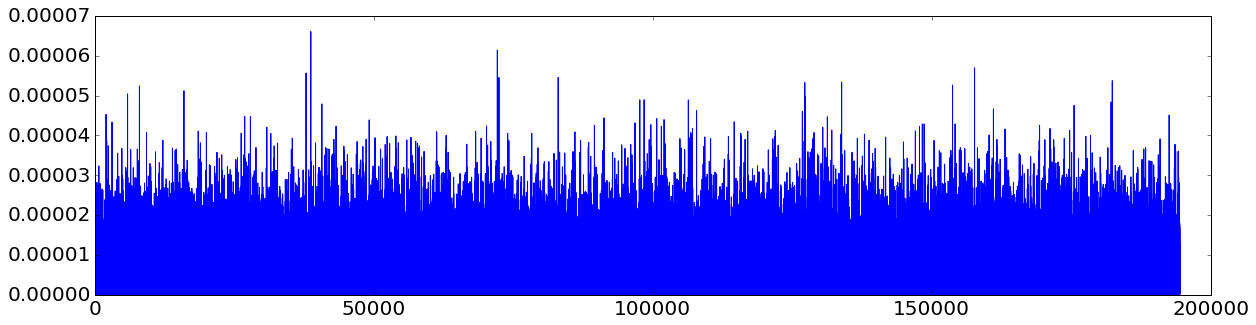

In [495]:
nq = 21
nv = 4
ns = nq**nv; print ns
a=1.0; pp=np.random.dirichlet([a]*ns); 

X = np.arange(ns)

pylab.figure(figsize=(20,5))
pylab.plot(X,pp)
#pylab.semilogy()
pylab.plot()

and we can compute the exact value of the entropy *e0* for this distribution.
The value will clearly depend on (but not be determined by) the hyper-parameter a. 

In [496]:
qq = pp[pp>0.0]
e0 = -np.sum(qq*np.log(qq))
print e0/np.log(nq)

3.86101575527


and then we will extract a random histogram with *nd* entries from *pp*

we can estimate entropy using the 'plugin' estimator

and with the NSB estimator

In [497]:
nd = nq*nv; h1 = np.random.multinomial(nd,pp)
#h1

#ep = endd.entropy(h1,algorithm='plugin'); err = ep-e0
ep = plugin(h1); err = ep-e0
print 'plugin alg.(n=%s):' % nd, ep, err, (err/e0)*100.0

e1 = endd.entropy(h1); err = e1-e0
print 'NSB    alg.(n=%s):' % nd, e1, err, (err/e0)*100.0

plugin alg.(n=84): 4.43081679884 -7.32413230047 -62.3067972357
NSB    alg.(n=84): 10.4823649609 -1.27258413843 -10.8259434191


check with larger amount of data: 

In [498]:
nd = 10*nq*nv; h1 = np.random.multinomial(nd,pp)
#h1

#ep = endd.entropy(h1,algorithm='plugin'); err = ep-e0
ep = plugin(h1); err = ep-e0
print 'plugin alg.(n=%s):' % nd, ep, err, (err/e0)*100.0

e1 = endd.entropy(h1); err = e1-e0
print 'NSB    alg.(n=%s):' % nd, e1, err, (err/e0)*100.0

plugin alg.(n=840): 6.72515013969 -5.02979895963 -42.788777026
NSB    alg.(n=840): 11.5005864875 -0.254362611832 -2.16387676104


check with a large amount of data: 

In [499]:
nd = 1000000*nq*nv; h2 = np.random.multinomial(nd,pp)

#ep = endd.entropy(h2,algorithm='plugin'); err = ep-e0
ep = plugin(h2); err = ep-e0
print 'plugin alg.(n=%s):' % nd, ep, err, (err/e0)*100.0

e2 = endd.entropy(h2); err = e2-e0
print 'NSB    alg.(n=%s):' % nd, e2, err, (err/e0)*100.0

plugin alg.(n=84000000): 11.7537250754 -0.00122402396344 -0.0104128393334
NSB    alg.(n=84000000): 11.7548857413 -6.33579733638e-05 -0.000538989772125


[]

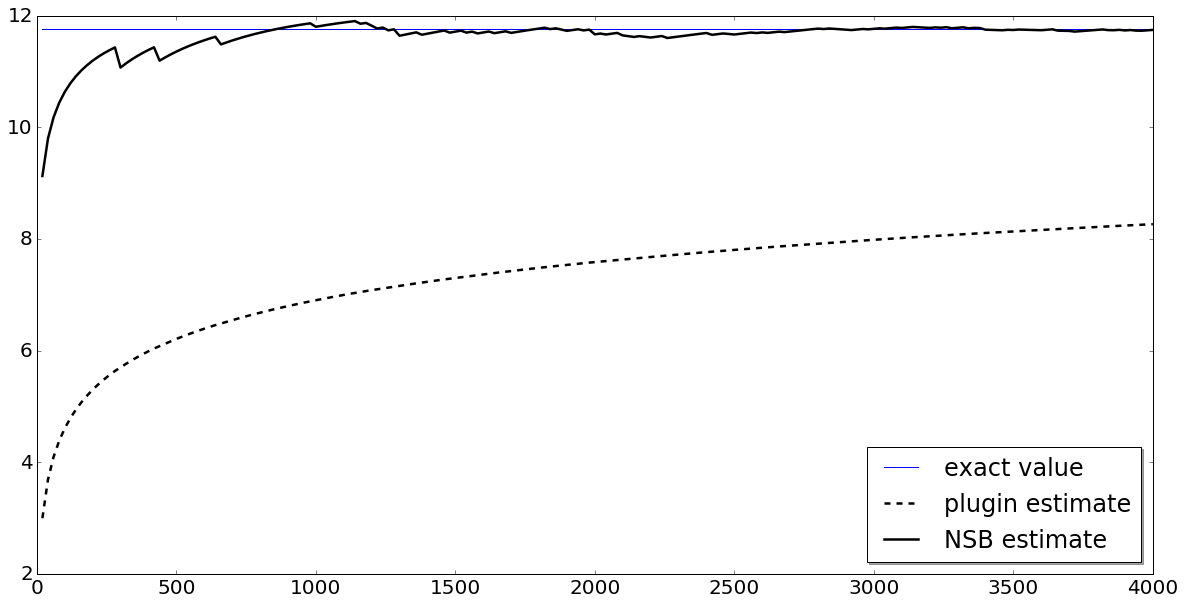

In [500]:
nd0 = 20; nd = nd0; hh = np.random.multinomial(nd0,pp)
X=[]
Y0=[]
Yplugin=[]
Ypseudo=[]
Ynsb=[]
for i in range(200): 
    X.append(nd);Y0.append(e0)
    #Yplugin.append(endd.entropy(hh,algorithm='plugin'));
    Yplugin.append(plugin(hh));
    #Ypseudo.append(endd.entropy(hh,algorithm='pseudo',a=1.0));
    Ynsb.append(endd.entropy(hh))
    nd += nd0
    hh += np.random.multinomial(nd0,pp)
    
pylab.figure(figsize=(20,10))
pylab.plot(X,Y0,label='exact value')
pylab.plot(X,Yplugin,'k--',label='plugin estimate',linewidth=2.5)
#pylab.plot(X,Ypseudo)
pylab.plot(X,Ynsb,'k',label='NSB estimate',linewidth=2.5)

legend = pylab.legend(loc='lower right', shadow=True)

#pylab.semilogy()
pylab.plot()